<a href="https://colab.research.google.com/github/Matheus-lucas/Filtros-Digitais/blob/main/TEEE_Simula%C3%A7%C3%B5es_Filtros_Ativos_Anal%C3%B3gicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Códigos dos Filtros Ativos utilizados na DIsciplina de Projeto e Análise de Filtros

## Bibliotecas Utilizadas

In [ ]:
# -*- coding: utf-8 -*-
 
#Importa Bibliotecas Necessárias
from math import log10, pi, sin, cos, ceil
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10,5)
import warnings
warnings.filterwarnings("ignore")

## Funções para plotagem e cálculo dos componentes

In [ ]:
# Classe para o plote dos gráficos
class Plotar():
  """
  Classe utilizada para mostrar as respostas do filtro
  """
  def __init__(self):
    return
  
  def mostrar(self, filtro = None, plot = True, plot_phase = False):
    """
    Uso: Plotar.plot(filtro, plot = bool, plot_phase = bool)
    Plota a resposta do filtro em módulo e fase
    filtro: filtro cuja resposta será plotada
    plot: bool, se True: mostra a resposta em módulo do filtro
    plot_phase:bool, se True: mostra a resposta em fase do filtro
    
    """

    # Define o Axis se for PA,PB ou PF,RF
    if filtro.tipo=="PA" or filtro.tipo=="PB":
        wa=max(filtro.Ws,filtro.Wp)
    else:
        wa = max(filtro.Wp2,filtro.Ws2)
    # Plotagem do Módulo
    plt.figure(1)
    plt.title("Resposta em Módulo")
    plt.ylabel('Magnitude[dB]')
    plt.xlabel('Frequency [rad/s]')

    plt.axis([0, 1.5*wa, filtro.As-10, filtro.Ap+10])

    plt.grid(True)
    if filtro.tipo == "PB" or filtro.tipo=="PA":
        plt.plot(filtro.Wp, filtro.Ap, 'ro')
        plt.text(filtro.Wp, filtro.Ap+1, 'Ap:')
        
        plt.plot(filtro.Ws, filtro.As, 'ro')
        plt.text(filtro.Ws, filtro.As+1, 'As:')
    else:
      plt.plot(filtro.Wp1, filtro.Ap, 'ro')
      plt.text(filtro.Wp1, filtro.Ap+1, 'Ap:')

      plt.plot(filtro.Wp2, filtro.Ap, 'ro')
      plt.text(filtro.Wp2, filtro.Ap+1, 'Ap:')
      
      plt.plot(filtro.Ws1, filtro.As, 'ro')
      plt.text(filtro.Ws1, filtro.As+1, 'As:')

      plt.plot(filtro.Ws2, filtro.As, 'ro')
      plt.text(filtro.Ws2, filtro.As+1, 'As:')

    w, y, phase = signal.bode(filtro.H,np.arange(0, 2*wa))
    plt.plot(w,y)
  
    if plot_phase:
      # Plotagem da Fase
      plt.figure(2)
      plt.grid(True)
      plt.title("Resposta em Fase")
      plt.ylabel('Magnitude [dB]')
      plt.xlabel('Frequency [rad/s]')
      plt.plot(w, phase, 'r')
    return

  def plotar_n(self, filtro):
    """
    uso: Plotar.plot_n(filtro)
    Mostra a resposta em módulo e fase do filtro normatizado
    filtro: filtro a ser plotado

    """

    # Plotagem do Módulo
    w, y, phase = signal.bode(filtro.H_norm,2)
    wa = 2
    plt.figure(1)
    plt.grid(True)
    plt.ylabel('Gain [dB]')
    plt.xlabel('Frequency [rad/s]')
    plt.axis([0, 1.5*wa, filtro.As, 5])
    plt.plot(w, y)
    return

  def delays(self,filtro):
      """
      uso: Plotar.delays(filtro)
      Mostra o group_delay do filtro
      filtro: filtro a ser plotado
      """
      filtro.func_tranf()
      w, filtro.delay_group = signal.group_delay((filtro.H_norm.num, filtro.H_norm.den))
      plt.figure(3)
      plt.ylabel('Group delay [samples]')
      plt.xlabel('Frequency [rad/sample]')
      plt.plot(w, filtro.delay_group)
      return


In [ ]:
class Componentes():
  """
  Classe utilizada para calcular os componentes
  """
  def __init__(self):
    return

  def calcula(self, filtro):
    """
    Uso: Componentes.calcula(filtro)
    Calcula o valor dos componentes para o circuito de 1ª ordem
    Se filtro.Ki! = None, será feita a transformação de impedância
    """
    r1 = 1
    r2 = filtro.G
    c = 0
    if filtro.tipo == "PA":
      c = 1/filtro.H.den[1]
    
    if filtro.tipo == "PB":
      c = 1/(filtro.G * filtro.H.den[1])

    if filtro.Ki != None:
      r1 = filtro.Ki * r1
      r2 = filtro.Ki * r2
      c = c / filtro.Ki   

    print("R1: {} Ohms, R2: {:.4f} Ohms, C {} mF".format(r1, r2, c*1000))
    return r1, r2, c

## Implementação dos Filtros Passivos

### Butterworth

In [ ]:
class butterworth(object):
    """
    Classe utilizada para criação dos filtros Butterworths
    """
    
    # Essa função inicializa os valores do filtro
    def __init__(self, tipo= None, Wp=0, Ws=0, Ap=0, As=0, Ws1=0 , Ws2 = 0, Wp1 = 0 , Wp2 = 0, Rl = None, N=0):
        """
        Instância o objeto e Define os parãmetros do Filtro
        uso: butterworth(tipo = str, Wp = int, Ws = int, As = int, Ap, = int, Ws1 = int, Ws2 = int, Wp1 = int, Wp2 = int, Rl = int, N = int)
        tipo: define o tipo deo Filtro: PB, PA, PF, RF
        Wp: Frequência de passagem dos Filtros PA e PB
        Ws: Frequência de Rejeição dos Fíltros PA e PB
        Ws1 e Ws2: Frequências da Faixa de Rejeição dos Filtros PF e RF
        Wp1 e Wp2: Frequências da Faixa de Passagem dos Filtros PF e RF
        Rl: Fator para a transformação de Impedância (default: None)
        N: ordem desejada para o Filtro (default: 0)
        """
        self.adj = -(Ap+1)
        self.G = 10**((Ap+1)/20)
        self.tipo = tipo
        self.Wp = Wp
        self.Ws = Ws
        # Realiza o ajuste dos ganhos
        self.Ap = Ap+self.adj
        self.As = As+self.adj
        self.Ki = Rl
        
        self.N=N
 
        # Pontos específicos do RF e PF
        if tipo == "PF" or self.tipo=="RF":
          self.Wp1=Wp1
          self.Wp2=Wp2
          self.Ws1=Ws1
          self.Ws2=Ws2
          self.Bp=Wp2-Wp1
          self.Bs=Ws2-Ws1
 
        elif tipo not in ["PB", "PA", "PF", "RF"]:
          raise Exception("Tipo nao definido")

        if (tipo=="PB" and Wp>Ws) or (tipo=="PA" and Ws>Wp) :
          raise Exception("Ordem Errada das frequências")

        elif (tipo=="PF" and Wp1<Ws1 and Wp2>Ws2) or (tipo=="RF" and Wp1>Ws1 and Wp2<Ws2):
          raise Exception("Ordem Errada das frequências")  
    
    # Essa função define e retorna a ordem do filtro
    def ordem(self):
      """
      Define a Ordem do Filtro, caso ela não seja informada
      uso: butterworth.ordem()
      """
      if self.N == 0:
        n,N,na,nb=0,0,0,0
        
        if self.tipo == "PB":
            n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(
                -self.Ap/10)) - 1)) / (2*log10(self.Ws/self.Wp))
            N = ceil(n)
        elif self.tipo == "PA":
            n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(
                -self.Ap/10)) - 1)) / (2*log10(self.Wp/self.Ws))
            N = ceil(n)
 
        # Define a ordem do PF
        elif self.tipo == "PF" :
           n = log10((10**(-self.As/10) - 1) / (10**(-self.Ap/10) - 1)) \
                                    / (2*log10(self.Bs/self.Bp))
           teste_w1=self.Wp1-self.Ws1
           teste_w2=self.Ws2-self.Wp2
           if teste_w1<0.5*teste_w2 or teste_w1 > 1.5*teste_w2 :
              nb = n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(
                  -self.Ap/10)) - 1)) / (2*log10(self.Ws2/self.Wp2))

              na = n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(
                  -self.Ap/10)) - 1)) / (2*log10(self.Wp1/self.Ws1))
          


           N = ceil(max(n,nb,na))
 
        #Define a ordem do RF  
        else:
          n = log10((10**(-self.As/10) - 1) / (10**(-self.Ap/10) - 1)) \
                                    / (2*log10(self.Bp/self.Bs))
                                  
          teste_w1=self.Ws1-self.Wp1
          teste_w2=self.Wp2-self.Ws2
          if teste_w1<0.5*teste_w2 or teste_w1 > 1.5*teste_w2 :
            na = n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(
                -self.Ap/10)) - 1)) / (2*log10(self.Wp2/self.Ws2))

            nb = n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(
                -self.Ap/10)) - 1)) / (2*log10(self.Ws1/self.Wp1))
        

          N = ceil(max(n,nb,na))
        
        self.N = N
      return self.N
        
    def freq_corte(self):
        """
        Retorna a frequência de corte(Wc), no caso do PA ou PB,ou a frequências de ressonância (W0), no caso de PF ou RF
        Uso: butterworth.freq_corte()
        """

        if self.tipo == "PB":
            Wc = self.Wp / pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            self.Wc = Wc
            return Wc
        elif self.tipo == "PA":
            Wc = self.Wp * pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            self.Wc = Wc
            return Wc
 
        elif self.tipo == "PF":
            # calcula as freq de corte do PF(Wc1>>Wc2)
 
            #Wc PB
            Wc1 = self.Wp2 / pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
 
            # Wc PA
            Wc2 = self.Wp1 *  pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            
            W0=np.sqrt(Wc1*Wc2)
            self.Bw=Wc1-Wc2
            self.Wcs=[Wc2,Wc1]
            self.W0=W0
            return self.Wcs
 
        elif self.tipo == "RF":
          # calcula as freq de corte do PF(Wc2>>Wc1)
 
            # Wc PB
            Wc1 = self.Wp1 / pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
 
            #Wc PA
            Wc2 = self.Wp2 *  pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            
            W0=np.sqrt(Wc1*Wc2)
            self.Bw=Wc2-Wc1
            self.Wcs=[Wc1,Wc2]
            self.W0=W0

            return self.Wcs
 
    
    def raizes_unit(self):
        """
        Define os polos do sistema normatizado para Wc/Wo = 1rad/s e Rl=1 ohm
        Uso: butterworth.raizes_unit()
        """

        Sk = list()
        for k in range(1, self.N + 1):
            Sk.append( complex(-sin( (pi*(2*k-1)) / (2*self.N) ), cos( 
                (pi*(2*k-1)) / (2*self.N) )))
        self.Sk = Sk
        return Sk
    
    def func_tranf(self):
        """
        Monta a função de transferência, realizando as transformações em frequência
        uso: butterworth.func_tranf()
        """
        self.raizes_unit()
        poli = list()
        poli = np.poly(self.Sk)
        coefReal = poli.real
        aux = 0

        coef = coefReal
        ## H(s) de PA e PB
        if self.tipo == "PB":
          num, den = signal.lp2lp(coef[-1], coef, self.Wc)

        elif self.tipo=="PA":
          num, den = signal.lp2hp(coef[-1], coef, self.Wc)
 
        ## H(S) para PF e RF
 
        elif self.tipo == "PF":

          #signal.lp2bp(numerador, denominador, w0, bw)
          num, den = signal.lp2bp(coef[-1], coef,self.W0, self.Bw)

        
        elif self.tipo=="RF":

          #signal.lp2bp(numerador, denominador, w0, bw)
          num, den = signal.lp2bs(coef[-1], coef,self.W0, self.Bw)


        self.H = signal.TransferFunction(self.G*num, den)
        self.H_norm = signal.TransferFunction(coef[-1], coef)
        self.Ap=self.Ap-self.adj
        self.As=self.As-self.adj
        return self.H
            
  

    def make_filter(self, plote = False, plote_fase=False):
      """
      Constroi o filtro, realizando todos os calculos com os parâmetros repassados a classe
      uso: butterworth.make_filter()
      """
      print("Tipo do Filtro:", self.tipo)
      self.ordem()
      print("Ordem:", self.N)
      self.freq_corte()
      self.raizes_unit()
      self.func_tranf()
      return
     
     

### Chebyshev I

In [ ]:
class chebyshev(object):
    
    def __init__(self, tipo= None, Wp = None, Ws = None, Ap = 0, As= 0, Ws1 = 0 , Ws2 = 0, Wp1 = 0 , Wp2 = 0, Rl = None, N=0):
        """
        Instância o objeto e Define os parãmetros do Filtro
        uso: chebyshev(tipo = str, Wp = int, Ws = int, As = int, Ap, = int, Ws1 = int, Ws2 = int, Wp1 = int, Wp2 = int, Rl = int, N = int)
        tipo: define o tipo deo Filtro: PB, PA, PF, RF
        Wp: Frequência de passagem dos Filtros PA e PB
        Ws: Frequência de Rejeição dos Fíltros PA e PB
        Ws1 e Ws2: Frequências da Faixa de Rejeição dos Filtros PF e RF
        Wp1 e Wp2: Frequências da Faixa de Passagem dos Filtros PF e RF
        Rl: Fator para a transformação de Impedância (default: None)
        N: ordem desejada para o Filtro (default: 0)
        """

        # Ajuste das amplitudes para os cálculos
        self.adj = -(Ap+1)
        self.Ap = Ap+self.adj
        self.As = As+self.adj

        #Ajuste do Ganho
        self.G = 10**((Ap+1)/20)
        self.tipo = tipo
        
        self.Wp = Wp
        self.Ws = Ws
        self.Ki=Rl
        self.N=N
 
        # Pontos específicos do RF e PF
        if tipo == "PF" or self.tipo=="RF":
          self.Wp1=Wp1
          self.Wp2=Wp2
          self.Ws1=Ws1
          self.Ws2=Ws2
          self.Bp=Wp2-Wp1
          self.Bs=Ws2-Ws1
 
        elif tipo not in ["PB", "PA", "PF", "RF"]:
          raise Exception("Tipo nao definido")

        if (tipo=="PB" and Wp>Ws) or (tipo=="PA" and Ws>Wp) :
          raise Exception("Ordem Errada das frequências")

        elif (tipo=="PF" and Wp1<Ws1 and Wp2>Ws2) or (tipo=="RF" and Wp1>Ws1 and Wp2<Ws2):
          raise Exception("Ordem Errada das frequências")
    
    
    # Essa função define e retorna a ordem do filtro


    def cal_e(self):
      """
      Realiza o cálculo do ajuste de ganho na faixa de passagem
      uso: chebyshev.cal_e()
      """
      e=np.sqrt(10**(-self.Ap/10)-1)
      self.e=e
      return self.e

    def ordem(self):
      """
      Define a Ordem do Filtro, caso ela não seja informada
      uso: chebyshev.ordem()
      """
      self.cal_e()
      if self.N==0:
          n,N=0,0
          
          if self.tipo == "PB":
              n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/self.e))\
                                            /np.arccosh(self.Ws/self.Wp)

          elif self.tipo == "PA":
              n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/self.e))\
                                          /np.arccosh(self.Wp/self.Ws)
            
  
          # Define a ordem do PF
          elif self.tipo == "PF" :
            n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/self.e))\
                                          /np.arccosh(self.Bs/self.Bp)
    

          #Define a ordem do RF  
          else:
            n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/self.e))\
                                        /np.arccosh(self.Bp/self.Bs)
          
          N = ceil(n)
          self.N = N
      return self.N
        

    def freq_corte(self):
        """
        Retorna a frequências de ressonância (W0), no caso de PF ou RF
        Uso: chebyshev.freq_corte()
        """

        if self.tipo=="PF" or self.tipo=="RF":
          self.Bw=self.Bp
          self.W0=np.sqrt(self.Wp1*self.Wp2)
          return self.W0
        
    def raizes_unit(self):
        """
        Define os polos do sistema normatizado para Wc/Wo = 1rad/s e Rl=1 ohm
        Uso: chebyshev.raizes_unit()
        """

        Sk = list()
        for k in range(1, self.N + 1):
            Pr = -np.sinh((1/self.N) * np.arcsinh(1/self.e) 
                               ) * np.sin(np.pi/(2*self.N)*(2*k - 1))
            Pi = np.cosh((1/self.N) * np.arcsinh(1/self.e) 
                              ) * np.cos(np.pi/(2*self.N)*(2*k - 1))

            Sk.append(complex(Pr, Pi))
        self.Sk = Sk
        return self.Sk
    
    def func_tranf(self):
        """
        Monta a função de transferência, realizando as transformações em frequência
        uso:  chebyshev.func_tranf()
        """
        self.raizes_unit()
        poli = list()
        poli = np.poly(self.Sk)
        coefReal = poli.real
        aux = 0
        # Faz o ajuste, se necessário
        aj=1
        if self.N % 2 == 0:
          aj=1/np.sqrt(1+self.e**2)
        coef= coefReal

        ## H(s) de PA e PB
        if self.tipo == "PB":
          num, den = signal.lp2lp(coef[-1], coef, self.Wp)

        elif self.tipo=="PA":
          num, den = signal.lp2hp(coef[-1], coef, self.Wp)
 
        ## H(S) para PF e RF
 
        elif self.tipo == "PF":

          #signal.lp2bp(numerador, denominador, w0, bw)
          num, den = signal.lp2bp(coef[-1], coef,self.W0, self.Bp)

        
        elif self.tipo=="RF":

          #signal.lp2bp(numerador, denominador, w0, bw)
          num, den = signal.lp2bs(coef[-1], coef,self.W0, self.Bp)


        self.H = signal.TransferFunction(num*self.G*aj, den)

        self.H_norm =  signal.TransferFunction(coef[-1], coef)
        self.H_norm.num = self.H_norm.num*aj
        self.Ap=self.Ap-self.adj
        self.As=self.As-self.adj
        return self.H

      
    def make_filter(self):

      """
      Constroi o filtro, realizando todos os calculos com os parâmetros repassados a classe
      uso: chebyshev.make_filter()
      """

      print("Tipo do Filtro:", self.tipo)
      self.cal_e()
      self.ordem()
      print("Ordem:", self.N)
      self.freq_corte()
      self.raizes_unit()
      self.func_tranf()
      return
     
     

### Chebyshev 2

In [ ]:
class chebyshev2(object):
    
    def __init__(self, tipo = None, Wp  = 0, Ws = 0, Ap = 0, As = 0, Ws1 = 0 , Ws2 = 0, Wp1 = 0 , Wp2 = 0, Rl=None, N=0):
        """
        Instância o objeto e Define os parãmetros do Filtro
        uso: chebyshev2(tipo = str, Wp = int, Ws = int, As = int, Ap, = int, Ws1 = int, Ws2 = int, Wp1 = int, Wp2 = int, Rl = int, N = int)
        tipo: define o tipo deo Filtro: PB, PA, PF, RF
        Wp: Frequência de passagem dos Filtros PA e PB
        Ws: Frequência de Rejeição dos Fíltros PA e PB
        Ws1 e Ws2: Frequências da Faixa de Rejeição dos Filtros PF e RF
        Wp1 e Wp2: Frequências da Faixa de Passagem dos Filtros PF e RF
        Rl: Fator para a transformação de Impedância (default: None)
        N: ordem desejada para o Filtro (default: 0)
        """

        self.tipo = tipo
        self.Wp = Wp
        self.Ws = Ws
            
        # Ajuste das amplitudes para os cálculos
        self.adj = -(Ap+1)
        self.Ap = Ap+self.adj
        self.As = As+self.adj

        #Ajuste do Ganho
        self.G = 10**(-(self.adj)/20)

        self.Ki=Rl
        self.N=N
 
        # Pontos específicos do RF e PF
        if tipo == "PF" or self.tipo=="RF":
          self.Wp1=Wp1
          self.Wp2=Wp2
          self.Ws1=Ws1
          self.Ws2=Ws2
          self.Bp=Wp2-Wp1
          self.Bs=Ws2-Ws1
          
 
        elif tipo not in ["PB", "PA", "PF", "RF"]:
          raise Exception("Tipo nao definido")

        if (tipo=="PB" and Wp>Ws) or (tipo=="PA" and Ws>Wp) :
          raise Exception("Ordem Errada das frequências")

        elif (tipo=="PF" and Wp1<Ws1 and Wp2>Ws2) or (tipo=="RF" and Wp1>Ws1 and Wp2<Ws2):
          raise Exception("Ordem Errada das frequências")
    


    def cal_e(self):
      """
      Realiza o cálculo do e
      uso: chebyshev2.cal_e()
      """
      e=1/np.sqrt(10**(-self.As/10)-1)
      self.e=e
      return

    def ordem(self):
      """
      Define a Ordem do Filtro, caso ela não seja informada
      uso: chebyshev2.ordem()
      """
      if self.N==0:
          self.cal_e()
          n,N=0,0
          
          if self.tipo == "PB":
              n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/(np.sqrt(10**(-self.Ap/10)-1))))\
                                            /np.arccosh(self.Ws/self.Wp)

          elif self.tipo == "PA":
              n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/(np.sqrt(10**(-self.Ap/10)-1))))\
                                          /np.arccosh(self.Wp/self.Ws)
            
  
          # Define a ordem do PF
          elif self.tipo == "PF" :
            n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/(np.sqrt(10**(-self.Ap/10)-1))))\
                                          /np.arccosh(self.Bs/self.Bp)
    

          #Define a ordem do RF  
          else:
            n = np.arccosh((np.sqrt(10**(-self.As/10)-1)/(np.sqrt(10**(-self.Ap/10)-1))))\
                                        /np.arccosh(self.Bp/self.Bs)
          
  
          N = ceil(n)
          self.N = N

      if self.N % 2 == 0:
          Nv = self.N / 2
      else:
          Nv = (self.N - 1) / 2
      
      self.Nv = int(Nv)
      return self.N



    def freq_corte(self):
        self.ordem()
        """
        Retorna  a frequências de ressonância (W0), no caso de PF ou RF
        Uso: chebyshev2.freq_corte()
        """

        if self.tipo=="PF" or self.tipo=="RF":
          self.Bw=self.Bp
          self.W0=np.sqrt(self.Wp1*self.Wp2)
          return self.W0

        
    
    
    def raizes_unit(self):
      """
      Define os polos do sistema normatizado para Wc/Wo = 1rad/s e Rl=1 ohm
      Uso: chebyshev2.raizes_unit()
      """
      D = 0
      Ok = 0
      Wk = 0
      Sk=list()
      for k in range(1, self.N+1):
          D = np.sinh((1/self.N) * np.arcsinh(1/self.e))**2 *\
              np.sin((np.pi/(2*self.N)) * (2*k - 1))**2 +\
              np.cosh((1/self.N) * np.arcsinh(1/self.e))**2 *\
              np.cos((np.pi/(2*self.N)) * (2*k - 1))**2
          
          Ok = -np.sinh((1/self.N) * np.arcsinh(1/self.e)) *\
                np.sin((np.pi/(2*self.N))*(2*k - 1)) / D
          
          Wk = -np.cosh((1/self.N) * np.arcsinh(1/self.e)) *\
                np.cos((np.pi/(2*self.N))*(2*k - 1)) / D
          
          Sk.append(complex(Ok, Wk))
      self.Sk = Sk
      return Sk
  
    def func_tranf(self):
      """
      Monta a função de transferência, realizando as transformações em frequência
      uso:  chebyshev.func_tranf()
      """
      self.raizes_unit()
      poli_polos = np.poly(self.Sk)
      polos = poli_polos.real

      poli_zeros = list()
      zeros = list()
      
      for i in range(1, self.Nv+1):
          Wz = 1 / np.cos((2*i - 1) * np.pi / (2*self.N))
          poli_zeros.append(complex(0, -Wz))
          poli_zeros.append(complex(0, Wz))
      
      poli_zeros = np.poly(poli_zeros)
      zeros = poli_zeros.real
      aux = polos[-1]
      
      # Ganho dc
      for i in range(0, len(polos)):
          polos[i] = polos[i] * zeros[-1]
      for i in range(0, len(zeros)):
          zeros[i] = zeros[i] * aux
      
      if self.tipo == "PB":
          num, den = signal.lp2lp(zeros, polos, self.Ws)

      elif self.tipo == "PA":
          num, den = signal.lp2hp(zeros, polos, self.Ws)

      elif self.tipo == "PF":
          num, den = signal.lp2bp(zeros, polos, self.W0, self.Bs)


      elif self.tipo == "RF":
          num, den = signal.lp2bs(zeros, polos, self.W0, self.Bs)

      H = signal.TransferFunction(num*self.G, den)

      self.H = H
      self.H_norm = signal.TransferFunction(zeros, polos)
      self.Ap=self.Ap-self.adj
      self.As=self.As-self.adj
      return self.H

    

    def make_filter(self):
      
      """
      Constroi o filtro, realizando todos os calculos com os parâmetros repassados a classe
      uso: chebyshev2.make_filter()
      """
      print("Tipo do Filtro:", self.tipo)
      self.cal_e()
      self.ordem()
      print("Ordem:", self.N)
      self.freq_corte()
      self.raizes_unit()
      self.func_tranf()
      return
     
     

### Bessel

In [ ]:
class bessel(object):
    
    def __init__(self, tipo = None, Wp = 0, Ap= 0, Ws= 0 , As= 0, Ws1 = 0, Wp1 = 0, Wp2 = 0, Ws2 = 0, Rl = None ):
        """
        Instância o objeto e Define os parãmetros do Filtro
        uso: chebyshev2(tipo = str, Wp = int, Ws = int, As = int, Ap, = int, Ws1 = int, Ws2 = int, Wp1 = int, Wp2 = int, Rl = int, N = int)
        tipo: define o tipo deo Filtro: PB, PA, PF, RF
        Wp: Frequência de passagem dos Filtros PA e PB
        Ws: Frequência de Rejeição dos Fíltros PA e PB
        Ws1 e Ws2: Frequências da Faixa de Rejeição dos Filtros PF e RF
        Wp1 e Wp2: Frequências da Faixa de Passagem dos Filtros PF e RF
        Rl: Fator para a transformação de Impedância (default: None)
        """
        self.tipo = tipo

        # Ajuste das amplitudes para os cálculos
        self.adj = -(Ap+1)
        self.Ap = Ap+self.adj
        self.As = As+self.adj

        #Ajusto do Ganho
        self.G = 10**((Ap+1)/20)

        self.Ki = Rl
        self.N = 0
        
        if tipo == "PB" or tipo == "PA":
            self.Wp = Wp
            self.Ws = Ws
        if tipo == "PF" or tipo == "RF":
            self.Wp1 = Wp1
            self.Wp2 = Wp2
            self.Ws1 = Ws1
            self.Ws2 = Ws2
            self.Bp = Wp2 - Wp1
            self.Bs = Ws2 - Ws1
    
    
    # Método principal, que chama todos os outros
    def make_filter(self, plote= True, plote_fase= True):
        """
        Realiza a busca da função pela função de transferência que atenda aos pontos
        uso: Bessel.make_filter(plot = bool, plot_fase = bool)
        plot: se True: mostra a resposta da FT em módulo
        plot_fase: se True: mostra a resposta em fase da FG
        """

        for N in range(1, 26):
            self.N = N
            
            den = self.den()
            
            if self.tipo == "PB":
                H = signal.TransferFunction(1, den)
            elif self.tipo == "PA":
                H = signal.TransferFunction(den[-1], den)
            w, y, phase = H.bode(w = np.arange(0, 10, step = 0.001))
            
            self.Wpl = self.calc_Wpl(w, y)
            
            if self.tipo == "PB":
                self.Kp = self.Wp/self.Wpl

            elif self.tipo == "PA":
                self.Kp = self.Wp*self.Wpl
            
            self.TransfFreq(H.num, H.den)

            w, y, phase = self.H.bode(w = np.arange(0, 200000, step = 1))
            
            self.Ks = y[self.Ws]
            
            if self.tipo == "PB":
                if (self.Wp >= self.Kp) and (self.As >= self.Ks):
                    break
            elif self.tipo == "PA":
                if (self.Wp <= self.Kp) and (self.As >= self.Ks):
                    break
            
            if N == 25:
                print("\nNão foi possível achar um filtro\n")

        print("Ordem: {}".format(self.N))
        self.H.num = self.H.num * self.G  
        self.Ap=self.Ap-self.adj
        self.As=self.As-self.adj
        return 

    
  
    def den(self):
        """
        Define e retorna o denominador da FT
        uso Bessel.den()
        """
        ak = list()
        ak.append(1)
        for k in range(0, self.N):
            ak.append(2*(self.N-k)*ak[k] / ((2*self.N-k)*(k+1)))
        den = ak[::-1]
        return den
    
    
    # Encontra o ponto em w correspondente ao Ap
    def calc_Wpl(self,w, y):
        """
        Faz a busca linear pela frequência em rad/s, cuja resposta da FT corresponde a AP
        uso Bessel.calc_Wpl(w = list(), y= list())
        w = lista de amplitudes(dB) da FT para cada frequência
        y = lista de frequências respectiva a cada amplitude
        """
        for i in y:
            if i < self.Ap or i == y[-1]:
                indice, = np.where(np.isclose(y, i))
                self.indice = indice
                aux = w[indice-1]
                break
        return aux
    
    
    def TransfFreq(self, zeros, polos):
        """
        Realiza a transformação de frequência da FT
        uso: Bessel.TransfFreq(zeros = list(), polos = list())
        Zeros: lista de zeros da FT
        Polos: lista de polos da FT
        """
        if self.tipo == "PB":
            num, den = signal.lp2lp(zeros, polos, self.Kp)
        elif self.tipo == "PA":
            num, den = signal.lp2hp(zeros, polos, self.Kp)
        elif self.tipo == "PF":
            num, den = signal.lp2bp(zeros, polos, self.Kp, self.Bp)
        elif self.tipo == "RF":
            num, den = signal.lp2bs(zeros, polos, self.Kp, self.Bp)
        self.H = signal.TransferFunction(num, den)
        return

## Exemplos

In [ ]:
plot = Plotar()
componentes = Componentes()

### Butterworth

* PB

Tipo do Filtro: PB
Ordem: 1
H:  TransferFunctionContinuous(
array([2775.95653751]),
array([1.00000000e+00, 1.96522673e+03]),
dt: None
)
2
1965.2267283602714


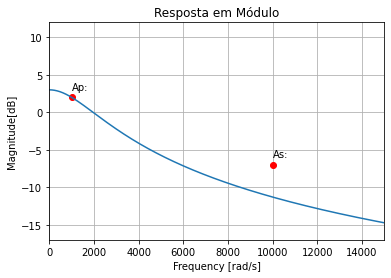

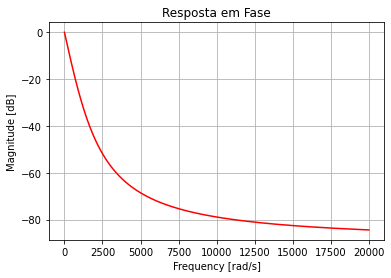

In [ ]:
PB=butterworth("PB", Ap=2, As=-7, Wp=1000,Ws=10000)
PB.make_filter()
print("H: ", PB.H)
print(PB.Ap)
print(PB.Wc)
plot.mostrar(PB, plot_phase=True)

In [ ]:
componentes.calcula(PB)

R1: 1 Ohms, R2: 1.4125 Ohms, C 0.3602361875949181 mF


(1, 1.4125375446227544, 0.0003602361875949181)

* PA


Tipo do Filtro: PA
Ordem: 1
TransferFunctionContinuous(
array([1.77827941, 0.        ]),
array([1.0000000e+00, 5.0884714e+03]),
dt: None
)
5088.471399095875


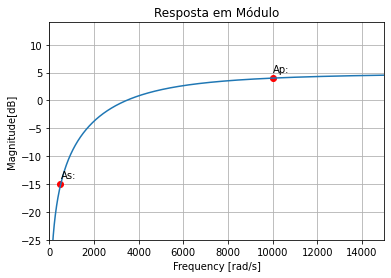

In [ ]:
PA=butterworth("PA", Ap=4, As=-15, Wp=10000,Ws=500)
PA.make_filter()
print(PA.H)
print(PA.Wc)
plot.mostrar(PA)

In [ ]:
componentes.calcula(PA)

R1: 1 Ohms, R2: 1.7783 Ohms, C 0.19652267283602715 mF


(1, 1.7782794100389228, 0.00019652267283602715)

*  PF

Tipo do Filtro: PF
Ordem: 9
H:  TransferFunctionContinuous(
array([1.53061735e+32, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]),
array([1.00000000e+00, 2.03539304e+04, 2.97141241e+08, 3.00425888e+12,
       2.46520175e+16, 1.62705673e+20, 9.07354562e+23, 4.24430758e+27,
       1.70248587e+31, 5.80325292e+34, 1.70248587e+38, 4.24430758e+41,
       9.07354562e+44, 1.62705673e+48, 2.46520175e+51, 3.00425888e+54,
       2.97141241e+57, 2.03539304e+60, 1.00000000e+63]),
dt: None
)
3162.2776601683795


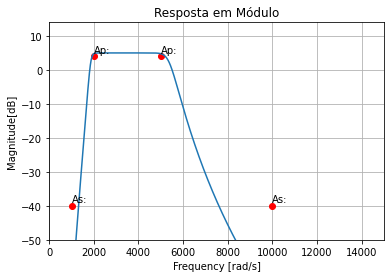

In [ ]:
PF = butterworth(tipo="PF",Wp1=2000, Wp2=5000,Ws1=1000, Ws2=10000, Ap=4, As=-40, Rl=25)
PF.make_filter()
print("H: ", PF.H)
print(PF.W0)
plot.mostrar(PF)

* RF

Tipo do Filtro: RF
Ordem: 9
TransferFunctionContinuous(
array([1.77827941e+00, 0.00000000e+00, 1.60045147e+08, 0.00000000e+00,
       6.40180588e+15, 0.00000000e+00, 1.49375470e+23, 0.00000000e+00,
       2.24063206e+30, 0.00000000e+00, 2.24063206e+37, 0.00000000e+00,
       1.49375470e+44, 0.00000000e+00, 6.40180588e+50, 0.00000000e+00,
       1.60045147e+57, 0.00000000e+00, 1.77827941e+63]),
array([1.00000000e+00, 4.72153046e+04, 1.20464250e+09, 2.09525284e+13,
       2.71348242e+17, 2.71823401e+21, 2.13768475e+25, 1.31922839e+29,
       6.31559358e+32, 2.30317913e+36, 6.31559358e+39, 1.31922839e+43,
       2.13768475e+46, 2.71823401e+49, 2.71348242e+52, 2.09525284e+55,
       1.20464250e+58, 4.72153046e+60, 1.00000000e+63]),
dt: None
)
3162.2776601683795


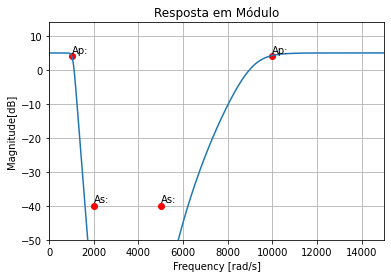

In [ ]:
RF = butterworth(tipo="RF",Wp1=1000, Wp2=10000,Ws1=2000, Ws2=5000, Ap=4, As=-40, Rl=10000)
RF.make_filter()
print(RF.H)
print(RF.W0)
plot.mostrar(RF)

### Chebyshev

* PB

Tipo do Filtro: PB
Ordem: 1
TransferFunctionContinuous(
array([2775.95653751]),
array([1.00000000e+00, 1.96522673e+03]),
dt: None
)


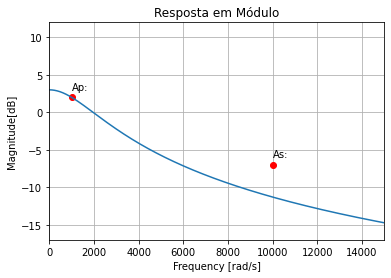

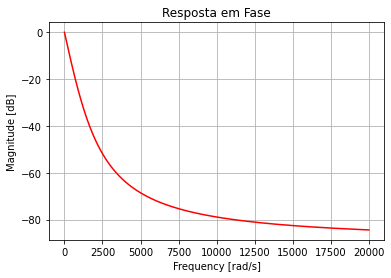

In [ ]:
PB2=chebyshev("PB", Ap=2, As=-7, Wp=1000,Ws=10000)
PB2.make_filter()
print(PB2.H)
plot.mostrar(PB2, plot_phase=True)

* PA

Tipo do Filtro: PA
Ordem: 1
TransferFunctionContinuous(
array([1.77827941, 0.        ]),
array([1.0000000e+00, 5.0884714e+03]),
dt: None
)


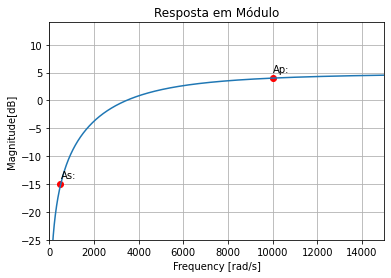

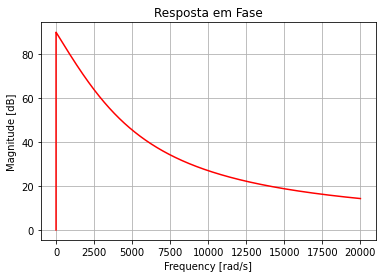

In [ ]:
PA2=chebyshev("PA", Ap = 4, As=-15, Wp=10000,Ws=500)
PA2.make_filter()
print(PA2.H)
plot.mostrar(PA2, plot_phase=True)

* PF

Tipo do Filtro: PF
Ordem: 3
TransferFunctionContinuous(
array([8.73680557e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
array([1.00000000e+00, 9.88341210e+02, 9.12384092e+07, 5.97917793e+10,
       2.73715228e+15, 8.89507089e+17, 2.70000000e+22]),
dt: None
)
5477.2255750516615


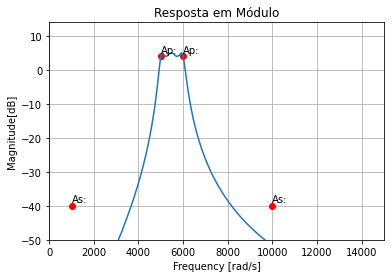

In [ ]:
PF2=chebyshev("PF", Ap=4, As=-40, Wp1=5000,Wp2=6000, 
              Ws1=1000,Ws2=10000)
PF2.make_filter()
print(PF2.H)
print(PF2.W0)
plot.mostrar(PF2)

* RF

Tipo do Filtro: RF
Ordem: 3
TransferFunctionContinuous(
array([1.41253754e+00, 0.00000000e+00, 8.47522527e+07, 0.00000000e+00,
       1.69504505e+15, 0.00000000e+00, 1.13003004e+22]),
array([1.00000000e+00, 2.01651509e+04, 1.88746137e+08, 1.84872498e+12,
       3.77492274e+15, 8.06606036e+18, 8.00000000e+21]),
dt: None
)
4472.13595499958


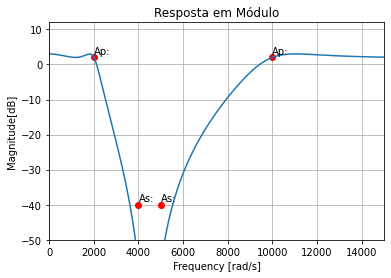

In [ ]:
RF2=chebyshev("RF", Ap=2, As=-40, Wp1=2000,Wp2=10000, 
              Ws1=4000,Ws2=5000,Rl=10000)
RF2.make_filter()
print(RF2.H)
print(RF2.W0)
plot.mostrar(RF2)

### Cheby2

* PB

Tipo do Filtro: PB
Ordem: 3
H:  TransferFunctionContinuous(
array([3.00007518e+02, 0.00000000e+00, 4.00010024e+10]),
array([1.00000000e+00, 6.02866486e+03, 1.81498455e+07, 2.83185410e+10]),
dt: None
)


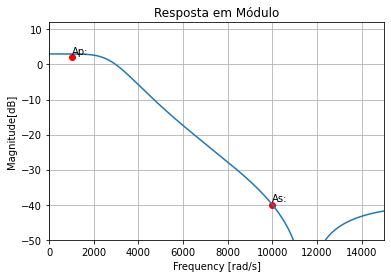

In [ ]:
PB3=chebyshev2("PB", Ap=2, As=-40, Wp=1000,Ws=10000)
PB3.make_filter()
print("H: ", PB3.H)
plot.mostrar(PB3)

* PA

Tipo do Filtro: PA
Ordem: 2


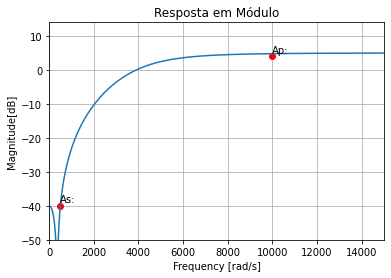

In [ ]:
PA3=chebyshev2("PA", Ap=4, As=-40, Wp=10000,Ws=500)
PA3.make_filter()
plot.mostrar(PA3)

* PF

Tipo do Filtro: PF
Ordem: 4


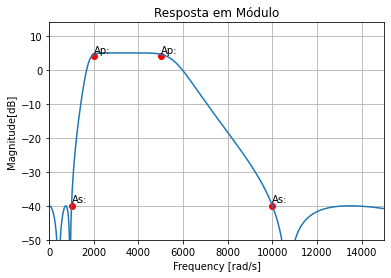

In [ ]:
PF3=chebyshev2("PF", Ap=4, As=-40, Wp1=2000,Wp2=5000, 
              Ws1=1000,Ws2=10000)
PF3.make_filter()
plot.mostrar(PF3)

* RF

Tipo do Filtro: RF
Ordem: 4


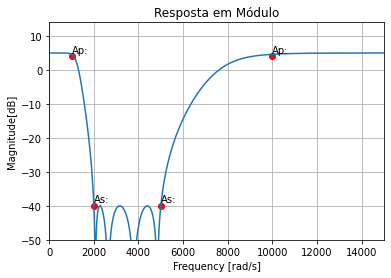

In [ ]:
RF3=chebyshev2("RF", Ap=4, As=-40, Wp1=1000,Wp2=10000, 
              Ws1=2000,Ws2=5000)
RF3.make_filter()
plot.mostrar(RF3)

### Bessel

* PB

Ordem: 3


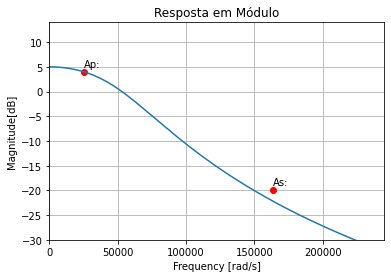

In [ ]:
PBbe=bessel("PB", Ap= 4, As=-20, Ws=163362,Wp= 25132)
PBbe.make_filter()
plot.mostrar(PBbe)

* PA

Ordem: 3


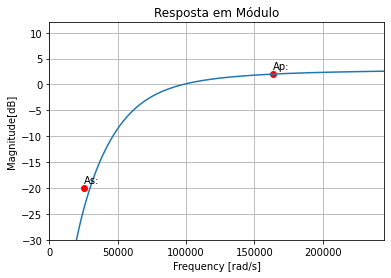

In [ ]:
PAbe=bessel("PA", Ap= 2, As=-20
, Ws=25132,Wp=163362)
PAbe.make_filter()
plot.mostrar(PAbe)

## Comparação entre os filtros


* PB

Tipo do Filtro: PB
Ordem: 4
Tipo do Filtro: PB
Ordem: 3
Tipo do Filtro: PB
Ordem: 3


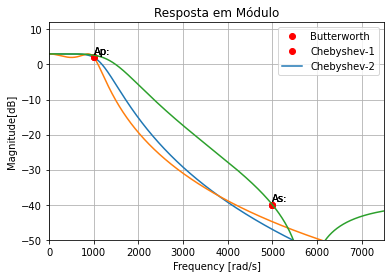

In [ ]:
PBB = butterworth(tipo="PB", Ap=2,As = -40,Wp = 1000 ,Ws = 5000)
PBB.make_filter()
plot.mostrar(PBB)

PC1B = chebyshev(tipo="PB", Ap=2,As = -40,Wp = 1000 ,Ws = 5000)
PC1B.make_filter()
plot.mostrar(PC1B)

PC2B = chebyshev2(tipo="PB", Ap=2,As = -40,Wp = 1000 ,Ws = 5000)
PC2B.make_filter()
plot.mostrar(PC2B)

plt.legend(["Butterworth", "Chebyshev-1", "Chebyshev-2"])
plt.show()

* PA

Tipo do Filtro: PA
Ordem: 4
Tipo do Filtro: PA
Ordem: 3
Tipo do Filtro: PA
Ordem: 3


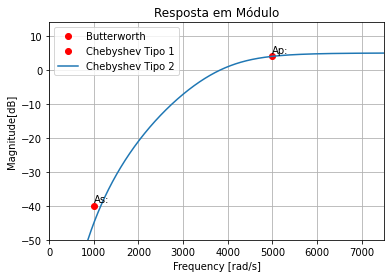

In [ ]:
PAB = butterworth(tipo="PA", Ap=4,As = -40,Wp = 5000 ,Ws = 1000)
PAB.make_filter()
plot.mostrar(PAB)

PC1A = chebyshev(tipo="PA", Ap=4,As = -40,Wp = 5000 ,Ws = 1000)
PC1A.make_filter()

PC2A = chebyshev2(tipo="PA", Ap=4,As = -40,Wp = 5000 ,Ws = 1000)
PC2A.make_filter()

plt.legend(["Butterworth", "Chebyshev Tipo 1", "Chebyshev Tipo 2"])

* PF

Tipo do Filtro: PF
Ordem: 9
Tipo do Filtro: PF
Ordem: 4
Tipo do Filtro: PF
Ordem: 4


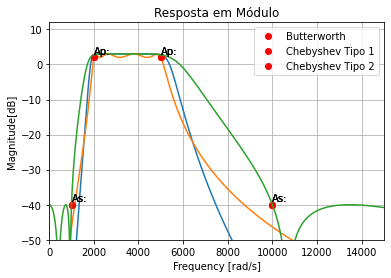

In [ ]:
RFB = butterworth(tipo="PF", Ap=2,As = -40,Wp1 = 2000, Wp2 = 5000, Ws1 = 1000, Ws2 = 10000)
RFB.make_filter()
plot.mostrar(RFB)



RFC1 = chebyshev(tipo="PF", Ap=2,As = -40,Wp1 = 2000, Wp2 = 5000, Ws1 = 1000, Ws2 = 10000)
RFC1.make_filter()
plot.mostrar(RFC1)

RFC2 = chebyshev2(tipo="PF", Ap=2,As = -40,Wp1 = 2000, Wp2 = 5000, Ws1 = 1000, Ws2 = 10000)
RFC2.make_filter()
plot.mostrar(RFC2)

plt.legend(labels=["Butterworth", "Chebyshev Tipo 1", "Chebyshev Tipo 2"])
plt.show()

### Group Delay do Chebyshev 2

In [ ]:
N = 2
ordens=list()
for i in  range(10):
  PB5=chebyshev(tipo="PB", Ap=4, As=-40 , Wp=0.5,Ws=2, Rl=50, N=N)
  PB5.make_filter()
  plot.delays(PB5)
  ordens.append("N = {}".format(PB5.N))
  plt.legend(ordens)
  N += 1